In [1]:
import os

import climlab
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# from filterpy.kalman import EnsembleKalmanFilter as EnKF
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
DATASETS_DIR = f"{BASE_DIR}/datasets"

fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

Loading NCEP surface temperature data ...


In [3]:
a0_ref = 0.354
a2_ref = 0.25
D_ref = 0.6
A_ref = 2.1
B_ref = 2.0

num_lat = len(Ts_ncep_annual)

nSteps_Episode = 200
nSteps = nSteps_Episode * 10
nEnsembles = 100

In [173]:
climlab_ebm = climlab.EBM_annual(
    a0=a0_ref,
    a2=a2_ref,
    D=D_ref,
    A=A_ref * 1e2,  # effective A (around 210)
    B=A_ref,
    num_lat=num_lat,
)
climlab_ebm.Ts[:] = 50.0  # initialise temperature state
xt = [np.array(climlab_ebm.Ts)]
climlab_ebm.step_forward()
xt += [np.array(climlab_ebm.Ts)]
xt = np.array(xt)

for i in range(nSteps - 1):
    climlab_ebm.step_forward()

In [184]:
# EnKF code from UoR - DA Course
# https://github.com/darc-reading/darc-training-2025/blob/edd4295c1aa00644b2722285d479e6276ba77566/tools/enkf.py#L221C1-L340C19


def kfs(
    x0_t,
    param,
    f,
    t,
    tobs,
    y,
    H,
    R,
    rho,
    ne,
    met,
    lam=None,
    loctype=None,
    back0="random",
    desv=2.0,
    param_estimate=False,
    alpha=None,
    seed=None,
    adaptive=False,
):
    """Data assimilation for Lorenz 1996 using Ensemble Kalman Filters.

    Parameters
    ----------
    x0_t : ndarray
        the real initial position
    param : int or list or tuple
        the initial model parameter, in L96 it is F, in L63 it is (sigma, b, r)
    f : func
        model propagation function. arguments: x0, tf, deltat, discard
    t : ndarray
        time array of the model (should be evenly spaced)
    tobs : ndarray
        time array of the observations (should be evenly spaced
        with a timestep that is a multiple of the model timestep)
    y : ndarray
        the observations. shape: (ny, nt)
    H : ndarray
        observation matrix
    R : ndarray
        the observational error covariance matrix
    rho : ndarray
        inflation for P.  Notice we multiply (1+rho)*Xpert
        or P*(1+rho)^2.
    ne : int
        number of ensemble member
    met : str
        a string containing the method: 'SEnKF', 'ETKF'
    lam : int
        the localization radius in gridpoint units.  If None,
        it means no localization.
    loctype : str
        a string indicating the type of localization: 'GC'
        to use the Gaspari-Cohn function, 'cutoff' for a sharp cutoff
    back0 : str
        Sampling the initial condition based on two methods.
        'random': initialise ensemble from sampled normal distribution
        'fixed': initialised ensemble from uniform intervals
    desv : float
        The range of the state ensemble.
        'random' : the standard deviation of normal
        'fixed': the range of uniform intervals
    param_estimate : bool
        Whether parameter estimation is used.
    alpha : float
        The range of the parameter ensemble.
        'random' : the standard deviation of normal
        'fixed': the range of uniform intervals
    seed : int
        Random seed for initial ensemble
    adaptive : bool
        switch for adaptive inflation (not implemented)

    Returns
    -------
    Xb: ndarray
        the background ensemble 3D array. shape: [nx, ne, nt]
    xb: ndarray
        background mean. shape: [nx, nt]
    Xa: ndarray
        the analysis ensemble 3D array. shape: [nx, ne, nt]
    xa: ndarray
        analysis mean. shape: [nx, nt]
    locmatrix: ndarray
        localization matrix (or None if lam is None)
    """

    # General settings
    # Number of observations and variables
    nt = len(t)
    ny, nx = H.shape
    if type(param) is float:
        param = np.array([param])
    Nparam = len(param)
    # For the true time
    tstep_truth = t[1] - t[0]
    # For the analysis (we assimilate everytime we get observations)
    tstep_obs = tobs[1] - tobs[0]
    # The ratio
    o2t = np.rint(tstep_obs / tstep_truth).astype(int)

    # Precreate the arrays for background and analysis
    Xb = np.empty((nx, ne, nt), order="F")
    Xb.fill(np.nan)
    Xa = np.empty((nx, ne, nt), order="F")
    Xa.fill(np.nan)
    Param_a = np.zeros((Nparam, ne, len(tobs)), order="F")
    # the state vector into the EnKF
    X = (
        np.empty((nx + Nparam, ne), order="F")
        if param_estimate
        else np.empty((nx, ne), order="F")
    )
    Hall = np.hstack((H, np.zeros((ny, Nparam)))) if param_estimate else H
    X.fill(np.nan)

    np.random.seed(seed)
    # For the original background ensemble
    # Fixed initial conditions for our ensemble (created ad hoc)
    if back0 == "fixed":
        Xb[..., 0] = np.linspace(-desv, desv, ne, endpoint=True)[None, :]
        if param_estimate:
            Param_a[..., 0] = np.linspace(-alpha, alpha, ne, endpoint=True)[
                None, :
            ]
    elif back0 == "random":
        Xb[..., 0] = np.random.normal(size=(nx, ne), scale=desv)
        Xb[..., 0] = Xb[..., 0] - np.mean(Xb[..., 0], axis=-1, keepdims=True)
        if param_estimate:
            Param_a[..., 0] = np.random.normal(size=(nx, ne), scale=desv)
            Param_a[..., 0] = Param_a[..., 0] - np.mean(
                Param_a[..., 0], axis=-1, keepdims=True
            )
    else:
        Xb[..., 0] = 0.0
        Param_a[..., 0] = 0.0

    Xb[..., 0] = Xb[..., 0] + x0_t[:, None]
    Param_a[:] = Param_a[:] + param[:, None, None]

    # Since we don't have obs at t=0 the first analysis is the same as
    # background
    Xa[..., 0] = Xb[..., 0]

    localDomainObsMask = None
    # Getting the R-localization weights
    if lam != None:
        locmatrix = getlocmat(nx, ny, H, lam, loctype)
        Blocmatrix = getlocmat(nx, nx, np.eye(nx), lam, loctype)

        if met == "ETKF":
            localDomainObsMask = getObsForLocalDomain(nx, lam, H)
    else:
        locmatrix = None
        Blocmatrix = np.ones((nx, nx))

    # if met != 'ETKF' or lam == None:
    #     adaptive = False

    # # deal with adaptive inflation
    # if adaptive:
    #     rho = np.empty(nx, order='F')
    #     rho[:] = 0.05

    # The following cycle evolve and assimilate for all time steps
    for j in range(len(tobs) - 1):
        # Evolve from analysis!
        xold = Xa[..., j * o2t]
        paramold = Param_a[..., j]  # [Nparam,M]

        # Time goes forward
        xnew = evolvemembers(xold, tstep_truth, o2t, f, paramold)
        # The new background
        Xb[..., j * o2t + 1 : (j + 1) * o2t + 1] = xnew[..., 1:]
        Xa[..., j * o2t + 1 : (j + 1) * o2t + 1] = xnew[..., 1:]

        X[:nx] = Xb[..., (j + 1) * o2t]
        if param_estimate:
            X[nx:] = paramold + alpha * np.random.randn(Nparam, ne)

        # The assimilation
        X, rho = enkfs(
            X,
            y[:, j + 1],
            Hall,
            R,
            rho,
            met,
            localDomainObsMask,
            locmatrix,
            adaptive,
        )
        Xa[..., (j + 1) * o2t] = X[:nx]
        if param_estimate:
            Param_a[..., j + 1] = X[nx:]

    # The background and analysis mean
    x_b = np.mean(Xb, axis=1)  # [N,M,t] -> [N, t]
    x_a = np.mean(Xa, axis=1)  # [N,M,t] -> [N, t]
    param_a = np.mean(Param_a, axis=1)

    if param_estimate:
        return Xb, x_b, Xa, x_a, Param_a, param_a, locmatrix, Blocmatrix
    else:
        return Xb, x_b, Xa, x_a, locmatrix, Blocmatrix


def enkfs(Xb, y, H, R, rho, met, localDomainObsMask, locmatrix, adaptive):
    """Performs the analysis using different EnKF methods.

    Parameters
    ----------
    Xb : ndarray
        the ensemble background (nx, ne)
    y : ndarray
        the observations (ny)
    H : ndarray
        the observation matrix (ny, nx)
    R : ndarray
        the obs error covariance matrix (ny, ny)
    rho : float
        inflation for P.  Notice we multiply (1+rho)*Xpert
        or P*(1+rho)^2.
    met : str
        a string that indicated what method to use
    localDomainObsMask : list
        observation mask used for each local analysis domain
        each element of the list contains observation mask for each domain
    locmatrix : ndarray
        localization matrix (nx, ny)
    adaptive : bool
        switch for adaptive inflation

    Returns
    -------
    Xa : ndarray
        the full analysis ensemble (nx, ne)
    """
    # General settings
    # The background information
    y = y.reshape(len(y), 1)  # array -> column vector
    sqR = msq(R)

    # Number of state variables, ensemble members and observations
    nx, ne = Xb.shape
    ny, _ = H.shape

    # Auxiliary matrices that will ease the computation of averages and
    # covariances
    U = np.ones((ne, ne)) / ne
    I = np.eye(ne)

    # Create the ensemble in Y-space
    Yb = np.empty((ny, ne))
    Yb.fill(np.nan)

    inv_ne = 1.0 / (ne - 1)
    # Now, we choose from one of three methods
    # Stochastic Ensemble Kalman Filter
    if met == "SEnKF":
        # The ensemble is inflated (rho can be zero)
        Xb_pert = (1 + rho) * (Xb @ (I - U))
        Xb = Xb_pert + Xb @ U

        # Map every ensemble member into observation space
        for jm in range(ne):
            Yb[:, jm] = H @ Xb[:, jm]
        # The matrix of perturbations
        Yb_pert = Yb @ (I - U)

        if not isinstance(locmatrix, np.ndarray):
            # The Kalman gain matrix without localization
            Khat = (
                inv_ne
                * Xb_pert
                @ Yb_pert.T
                @ minv(inv_ne * Yb_pert @ Yb_pert.T + R)
            )
        else:
            # The Kalman gain with localization
            Caux = locmatrix * (Xb_pert @ Yb_pert.T)
            Khat = inv_ne * Caux @ minv(inv_ne * H @ Caux + R)

        # Fill Xa (the analysis matrix) member by member using perturbed observations
        Xa = np.empty((nx, ne), order="F")
        Xa.fill(np.nan)
        for jm in range(ne):
            yaux = y + sqR @ np.random.randn(ny, 1)
            yaux = np.squeeze(yaux)
            Xa[:, jm] = Xb[:, jm] + Khat @ (yaux - Yb[:, jm])

    # Ensemble Transform Kalman Filter
    elif met == "ETKF":
        if not isinstance(locmatrix, np.ndarray):
            # The ensemble is inflated (rho can be zero)
            Xb_pert = (1 + rho) * (Xb @ (I - U))
            Xb = Xb_pert + Xb @ U

            # Map every ensemble member into observation space
            for jm in range(ne):
                Yb[:, jm] = H @ Xb[:, jm]
            # The matrix of perturbations
            Yb_pert = Yb @ (I - U)

            # Means
            xb_bar = Xb @ np.ones((ne, 1)) / ne
            yb_bar = Yb @ np.ones((ne, 1)) / ne

            # The method without localization (ETKF)
            Pa_ens = minv(
                (ne - 1) * np.eye(ne) + Yb_pert.T @ minv(R) @ Yb_pert
            )
            Wa = msq((ne - 1) * Pa_ens)  # matrix square root (symmetric)
            wa = Pa_ens @ (Yb_pert.T @ (minv(R) @ (y - yb_bar)))
            # get analysis perturbations
            Xa_pert = Xb_pert @ Wa
            xa_bar = xb_bar + Xb_pert @ wa
            Xa = Xa_pert + xa_bar @ np.ones((1, ne))
        else:
            Xb_pert = Xb @ (I - U)
            # Map every ensemble member into observation space
            for jm in range(ne):
                Yb[:, jm] = H @ Xb[:, jm]
            # The matrix of perturbations
            Yb_pert = Yb @ (I - U)
            # Means
            xb_bar = Xb @ np.ones((ne, 1)) / ne
            yb_bar = Yb @ np.ones((ne, 1)) / ne
            Xa, rho = letkf(
                Xb_pert,
                xb_bar,
                Yb_pert,
                yb_bar,
                y,
                H,
                rho,
                localDomainObsMask,
                locmatrix,
                R,
                adaptive,
            )
    else:
        raise NotImplementedError(
            f"{met} is not implemented, try ETKF or SEnKF"
        )

    return Xa, rho

In [185]:
def createH(obsgrid, nx, footprint=None):
    """observation operator for L96 model

    Parameters
    ----------
    obsgrid : str
        Observation grid type. With following choices:
        `all`: observe all grid points
        `1010`: observe every other grid points
        `landsea`: observe left half grid points
        `foot_cent`: only one observation used, which is a weigted
                     average of grid points within a radius of
                     the centre of the domain. The weigting is given
                     by a Gaussian structure function.
        `foot_6`: 6 observations and each observation is a weighted
                  average of gridpoints within a radius of
                  one central grid point. The radius is determined by
                  half of the footprint, and the 6 central grid points
                  are equally distributed on the model domain.
    nx : float
       The size of the state space
    footprint : float
       Number of gridpoints observed by one variable
       only for the obsgrid='foot_6'option

    Returns
    -------
    ny : int
        Number of observations
    H : ndarray
        Linear observation operator
    """
    _ny = {
        "all": nx,
        "1010": nx // 2,
        "landsea": nx // 2,
        "foot_cent": 1,
        "foot_6": 6,
    }

    if obsgrid not in _ny:
        raise NotImplementedError(
            f"observation network option {obsgrid} not supported"
        )

    ny = _ny[obsgrid]
    H = np.zeros((ny, nx), order="F")

    if obsgrid == "all":
        # Observe all
        np.fill_diagonal(H, 1.0)
    elif obsgrid == "1010":
        # Observe every other variable
        for i in range(ny):
            H[i, 2 * i] = 1.0
    elif obsgrid == "landsea":
        # Observe left half ("land/sea" configuration)
        np.fill_diagonal(H, 1.0)
    elif obsgrid == "foot_cent":
        # Observe footprint of half of the domain (in the centre)
        # A Gaussian-shaped structure function
        L = nx / 4.0  # Lengthscale of the footprint
        factor = -1.0 / (2.0 * L * L)
        centre = nx // 2
        observed = np.arange(centre - nx // 4, centre + nx // 4)
        distance = centre - observed
        H[0, centre - nx // 4 : centre + nx // 4] = np.exp(
            factor * distance * distance
        )
        # normalise
        H[0] /= np.sum(H[0])
    elif obsgrid == "foot_6":
        # Six observations footprint of half of the domain
        # (throughout domain)
        # A Gaussian-shaped structure function
        # footprint=5
        assert (
            footprint is not None
        ), "footprint is not given with foot_6 obsgrid"
        L = footprint / 2  # Lengthscale of the footprints
        factor = -1.0 / (2.0 * L * L)
        for i in range(ny):
            centre = int(((i + 0.5) * nx) / ny)
            position = centre - int(L) + np.arange(int(footprint))
            distance = position - centre
            position = np.mod(position, nx)
            H[i, position] = np.exp(factor * distance * distance)
            # normalise
            H[i] /= np.sum(H[i])

    return ny, H


def gen_obs(t, x, period_obs, H, var_obs, seed=None, skip0=False):
    """This function generates (linear) observations from a state.

    Parameters
    ----------
    t : ndarray
        one dimensional array of model times
    x : ndarray
        2D array of the model state. shape: (nx, nobt)
    period_obs : int
        number of time steps between observations
        ? todo: change name?
    H : ndarray
        Observation operator matrix. shape: (ny, nx)
    var_obs : ndarray or int
        the observation error variance.
        It can be a scalar or a 1D array with size of ny
    seed : int
        the random number generator seed
    skip0 : bool
        whether we skip the first time step

    Returns
    -------
    tobs : ndarray
        The one dimensional time array of the observations
    y : ndarray
        The observations, shape: (ny, nobt)
    R : ndarray
        The observational error covariance matrix
    """
    # Extract number of observations (per time) and size of state space
    ny, nx = H.shape

    # Determine the observation times
    tobs = t[::period_obs]

    # Initialise observations array
    y = np.zeros((ny, len(tobs)), order="F")
    y.fill(np.nan)

    # Make the (diagonal) obs error covariance matrix
    R = var_obs * np.eye(ny)

    # The cycle that generates the observations
    np.random.seed(seed)
    std_obs = np.sqrt(var_obs)

    t0 = 1 if skip0 else 0
    for time in range(t0, len(tobs)):
        # Let's do the matrix multiplication explicitly
        # for ob in range(ny):
        # noise = std_obs * np.random.randn()
        # y[ob, time] = np.sum(H[ob, :] * x[:, period_obs * time]) + noise

        # not so sure why it is explicit, more like a fortran way...
        # I think using H@x as written in the equations is straightforward
        # noise = np.random.normal(scale=std_obs, size=ny)
        noise = np.squeeze(std_obs * np.random.randn(ny, 1))
        y[:, time] = H @ x[:, period_obs * time] + noise

    return tobs, y, R


def msq(B):
    if np.allclose(np.diag(np.diag(B)), B):
        return np.sqrt(B)
    U, s, Vh = np.linalg.svd(B)
    B_sq = (U * np.sqrt(s[..., None, :])) @ Vh
    return B_sq


def minv(B):
    if np.allclose(np.diag(np.diag(B)), B):
        return np.diag(1.0 / np.diag(B))
    U, s, Vh = np.linalg.svd(B)
    B_sq = (U / s[..., None, :]) @ Vh
    return B_sq

In [174]:
xt = xt.squeeze().T

In [179]:
x0 = xt[:, 0]
param = np.array([A_ref, B_ref])

t = np.arange(xt.shape[1])

inflation = 0.01
n_ens = 10
da_method = "ETKF"
alpha = 0.1
seed = 42

In [180]:
_, H = createH("all", xt.shape[0])
tobs, y, R = gen_obs(t, xt, 1, H, 1, seed, skip0=True)

In [181]:
tobs

array([0, 1])

In [182]:
# write the f function

Xb, xb, Xa, xa, Pa, pa, _, _ = kfs(
    x0,
    param,
    lambda a, b, c, d, e: np.array([a, a]).T,
    t,
    tobs,
    y,
    H,
    R,
    inflation,
    n_ens,
    da_method,
    back0="fixed",
    desv=1.0,
    alpha=alpha,
    param_estimate=True,
    seed=seed,
)

In [186]:
pa

array([[2.1       , 2.03455729],
       [2.        , 1.83014849]])

In [5]:
class Forecast:
    def __init__(self):
        self.zforecast = None


forecast = Forecast()


def hx(x):
    """
    Measurement function for EnKF.
    """
    return forecast.zforecast


def fx(x, dt):
    """
    State transition function (identity, as process noise is added via Q).
    """
    return x


ebm = climlab.EBM_annual(
    a0=a0_ref,
    a2=a2_ref,
    D=D_ref,
    A=A_ref * 1e2,  # effective A (around 210)
    B=B_ref,
    num_lat=num_lat,
)
ebm.Ts[:] = 50.0  # initialise temperature state

enkf = EnKF(
    x=np.array([A_ref, B_ref]),  # initial guess for [A, B]
    P=np.diag([2.1**2, 0.05**2]),  # initial covariance
    dim_z=num_lat,  # observation dimension: full Ts profile
    dt=1.0,
    N=nEnsembles,
    hx=hx,
    fx=fx,
)

enkf.R = np.eye(num_lat) * 1e-5  # adjust based on observation uncertainty
enkf.Q = np.diag([1e-3, 1e-3])  # allow [A, B] to drift slightly

A_hist, B_hist = [], []

for i in tqdm(range(nSteps)):
    if i % nSteps_Episode == 0:
        ebm = climlab.EBM_annual(
            a0=a0_ref,
            a2=a2_ref,
            D=D_ref,
            A=A_ref * 1e2,  # effective A (around 210)
            B=B_ref,
            num_lat=num_lat,
        )
        ebm.Ts[:] = 50.0

    A_i, B_i = enkf.x[0], enkf.x[1]

    ebm.subprocess["LW"].A = A_i * 1e2
    ebm.subprocess["LW"].B = B_i
    ebm.step_forward()

    forecast.zforecast = ebm.Ts.copy().reshape(-1)
    z = Ts_ncep_annual.to_numpy()

    enkf.predict()
    enkf.update(z)

    A_hist.append((enkf.x[0], 1 * np.sqrt(enkf.P[0, 0])))
    B_hist.append((enkf.x[1], 1 * np.sqrt(enkf.P[1, 1])))

A_hist = np.array(A_hist)
B_hist = np.array(B_hist)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 158.80it/s]


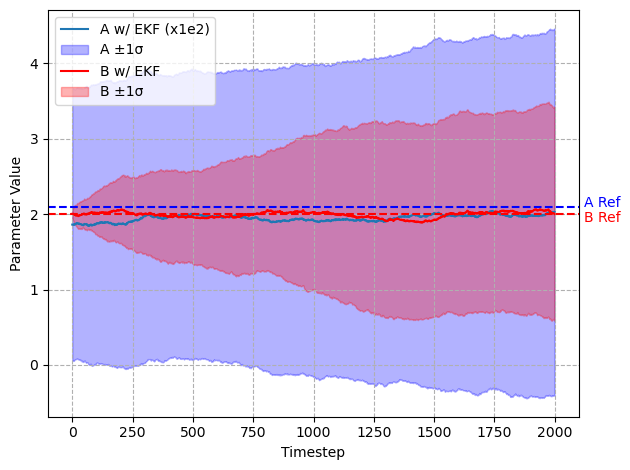

In [6]:
fig = plt.figure()
ax = fig.gca()

A_mean, A_spread = A_hist[:, 0], A_hist[:, 1]
xtime = range(0, nSteps)
plt.plot(xtime, A_mean, label="A w/ EKF (x1e2)")
plt.fill_between(
    xtime,
    A_mean - A_spread,
    A_mean + A_spread,
    alpha=0.3,
    color="blue",
    label="A ±1σ",
)
plt.axhline(A_ref, color="blue", linestyle="--")

B_mean, B_spread = B_hist[:, 0], B_hist[:, 1]
plt.plot(xtime, B_mean, label="B w/ EKF ", color="red")
plt.fill_between(
    xtime,
    B_mean - B_spread,
    B_mean + B_spread,
    alpha=0.3,
    color="red",
    label="B ±1σ",
)
plt.axhline(B_ref, color="red", linestyle="--")

xmax = ax.get_xlim()[1]
plt.text(xmax + 0.01 * xmax, A_ref + 0.05, "A Ref", color="blue", va="center")
plt.text(xmax + 0.01 * xmax, B_ref - 0.05, "B Ref", color="red", va="center")

plt.xlabel("Timestep")
plt.ylabel("Parameter Value")
plt.legend(loc="upper left")
plt.grid(ls="--")
plt.tight_layout()

plt.show()

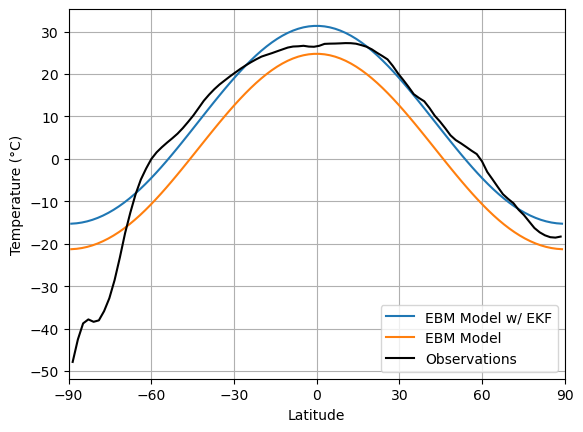

In [7]:
fig = plt.figure()
ax = fig.gca()
ax.plot(ebm.lat, ebm.Ts, label="EBM Model w/ EKF")
ax.plot(climlab_ebm.lat, climlab_ebm.Ts, label="EBM Model")
ax.plot(lat_ncep, Ts_ncep_annual, label="Observations", c="k")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Latitude")
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.legend()
ax.grid()

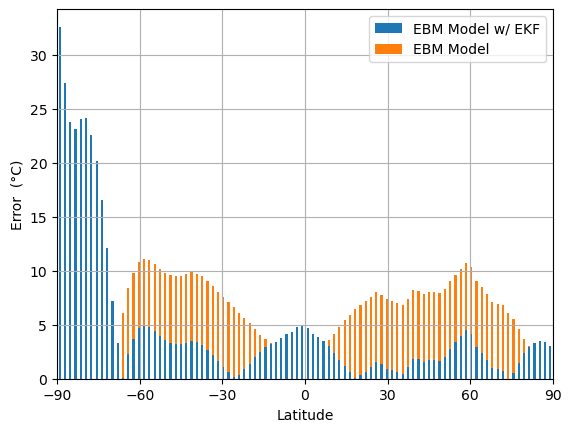

In [8]:
fig = plt.figure()
ax = fig.gca()
ax.bar(
    x=ebm.lat,
    height=np.abs(ebm.Ts.reshape(-1) - Ts_ncep_annual.values),
    label="EBM Model w/ EKF",
)
ax.bar(
    x=climlab_ebm.lat,
    height=np.abs(climlab_ebm.Ts.reshape(-1) - Ts_ncep_annual.values),
    label="EBM Model",
    zorder=-1,
)
ax.set_ylabel("Error  (°C)")
ax.set_xlabel("Latitude")
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.legend()
ax.grid()

In [9]:
np.mean((ebm.Ts.reshape(-1) - Ts_ncep_annual.values)[15:-15] ** 2)

Field(8.42586922)

In [10]:
np.mean((climlab_ebm.Ts.reshape(-1) - Ts_ncep_annual.values)[15:-15] ** 2)

Field(55.59260877)